In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.dataset_custom import *
from models.lstm_ae import *
from models.conv_ae import *
import torch
import random
from torchvision.transforms import transforms as T
from config import *

import numpy as np

In [115]:
model_list = os.listdir(model_results+ 'conv_ae')
os.listdir(model_results+ 'conv_ae')

['conv_ae_16_ft_4s_sc.pth', 'conv_ae_4_ft_4s_sc.pth']

In [116]:
model_num = 0
#ae_16_ft_4s_sc
print(model_list[model_num])

conv_ae_16_ft_4s_sc.pth


In [117]:
checkpoint  = torch.load(model_results +  'conv_ae' + '/' + model_list[model_num])
params_conf = checkpoint['param_conf']

In [118]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

data_path = os.path.join('..',params_conf['data_path'].strip('./'))
dataset = params_conf['dataset']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

In [119]:
transform = T.Compose([
                       T.ToTensor(),
                       #T.Lambda(lambda x: x.permute(0, 2, 1))
                       ])

In [120]:
xdf = pd.read_pickle(os.path.join(data_path, dataset))

In [121]:
if columns_subset:
    cols = cols[:columns_subset]
dataRaw = xdf[cols].dropna()

if dataset_subset:
    dataRaw = dataRaw.iloc[:dataset_subset, :]

df = dataRaw.copy()
x = df.values

if scaled:
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    dfNorm = pd.DataFrame(x_scaled, columns=df.columns)
else:
    dfNorm = pd.DataFrame(x, columns=df.columns)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(dfNorm, dfNorm, \
                                                    train_size=train_val_split\
                                                    , shuffle=False)
df_train = pd.DataFrame(X_train, columns=dfNorm.columns)
df_test = pd.DataFrame(X_test, columns=dfNorm.columns)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [123]:
train_dataset = Dataset_seq(df_train, target = target, sequence_length = sequence_length,
                            out_window = out_window, prediction=predict,\
                            transform=transform)
train_iter = DataLoader(dataset=train_dataset,\
                        batch_size=batch_size, shuffle=True)

test_dataset = Dataset_seq(df_test, target = target, \
                           sequence_length = sequence_length,
                            out_window = out_window, prediction=predict,\
                           transform=transform)
test_iter = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [124]:
num_batch = 20

x = np.zeros((num_batch, len(columns), sequence_length))
for i in range(num_batch):
    
    x[i,:,:] = test_iter.dataset.df_data.iloc[i*sequence_length:(i+1)*sequence_length,:]\
    .values
x = torch.from_numpy(x).float()
#x = torch.permute(x, (0,2,1))
x = torch.unsqueeze(x, 1)

In [125]:
model = CONV_AE(in_channel=1,heigth=sequence_length, width=len(columns),
                        kernel_size=kernel_size, filter_num=filter_num,
                 latent_dim=latent_dim, \
        n_layers=n_layers, activation = activation).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE(
  (act): ReLU()
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_2): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_runni

CONV_AE(
  (act): ReLU()
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (enc_lay_2): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [126]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [127]:
count_parameters(model)

39965

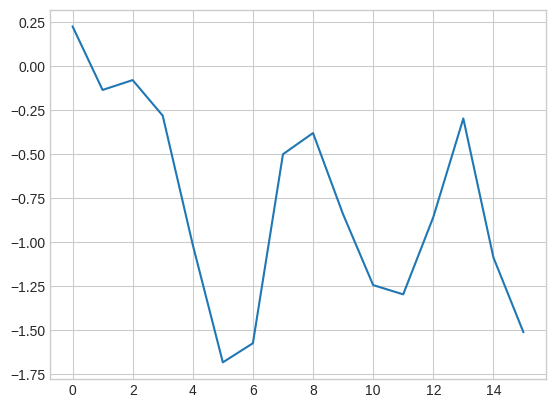

In [128]:
yo = model(x.to('cuda'))

x = torch.squeeze(x)
yo = torch.squeeze(yo)

feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

In [111]:
#sequence_length=50
#out_window=10

In [129]:
x_limit = 100

If transpose the input matrix in input to have [Feat, time] in place of [time, feat]
then we need to invert below [:x_limit,i] to [i:x_limit]

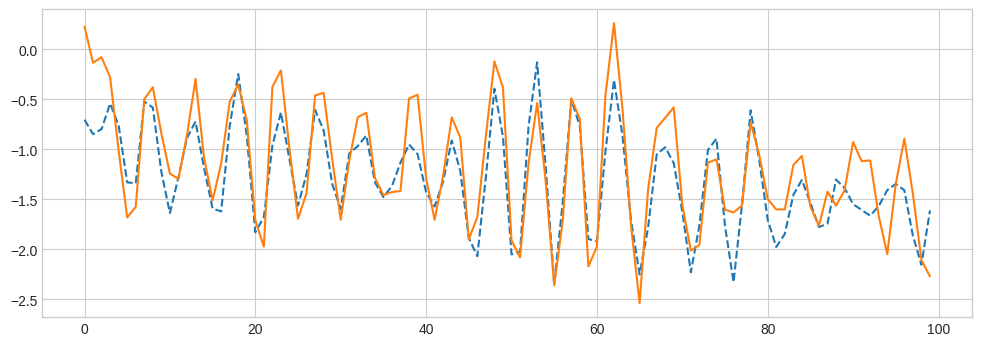

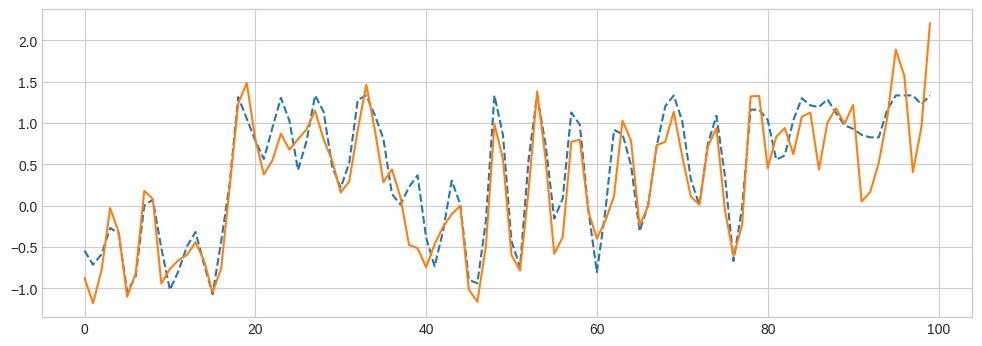

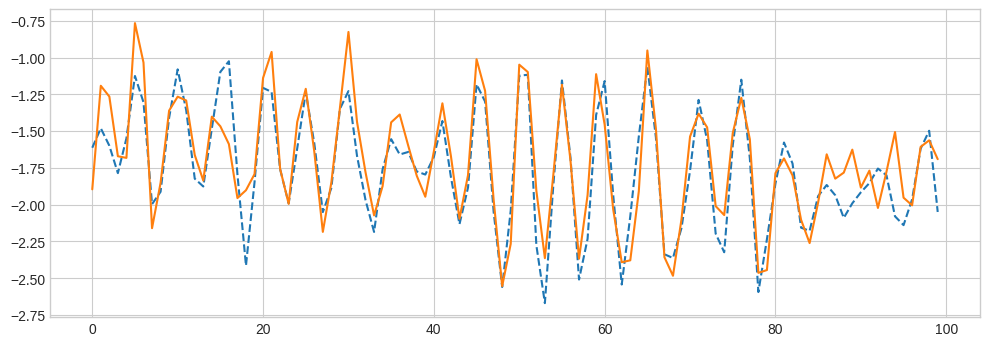

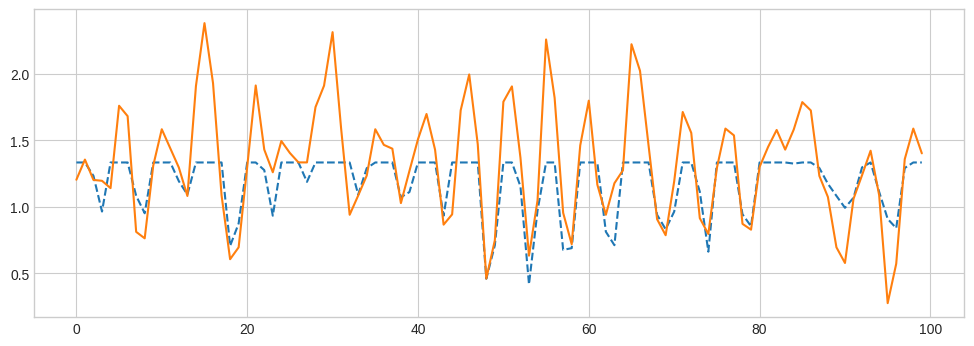

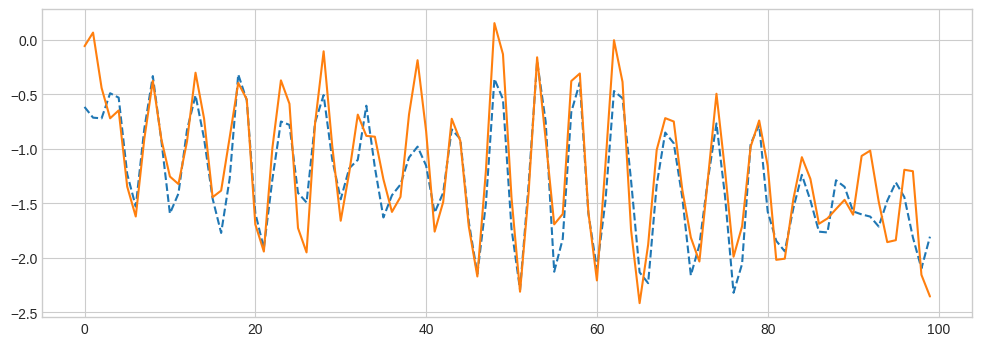

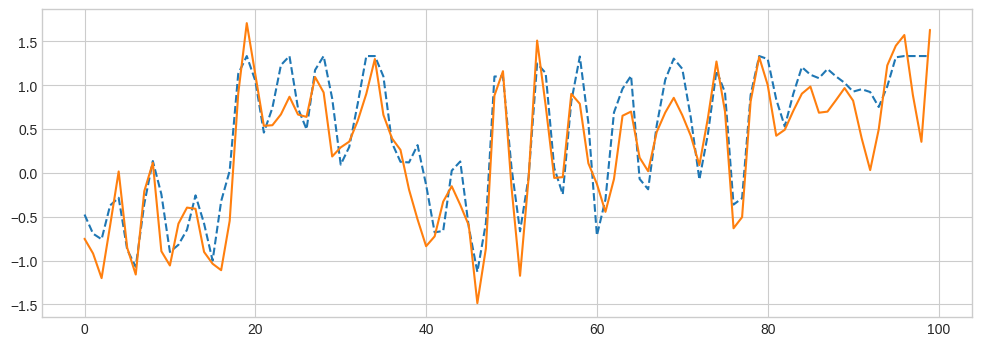

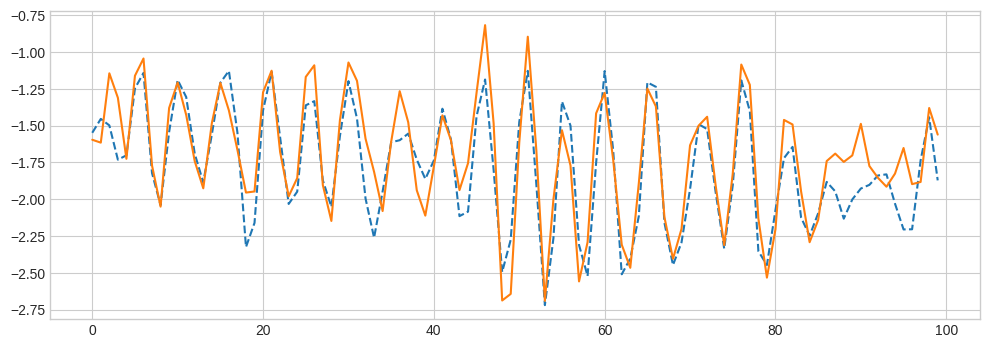

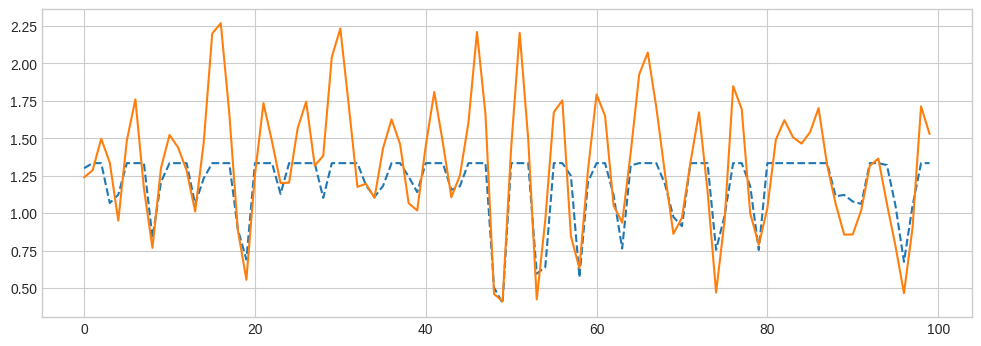

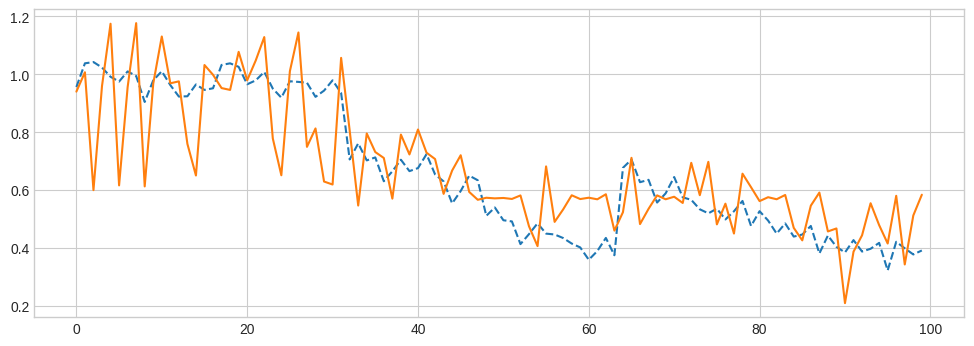

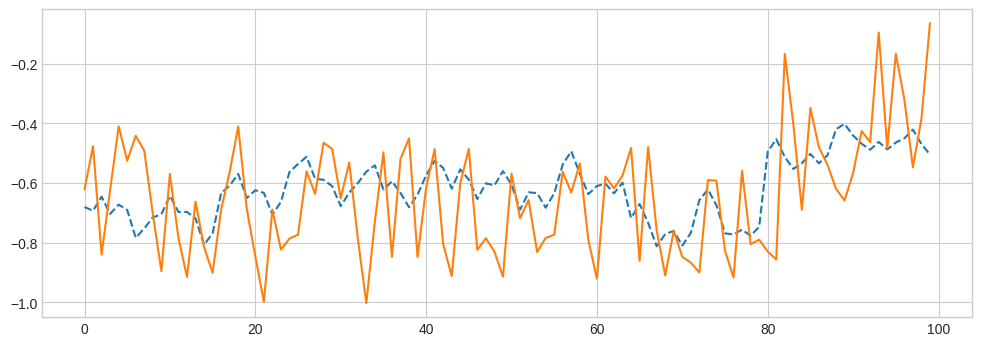

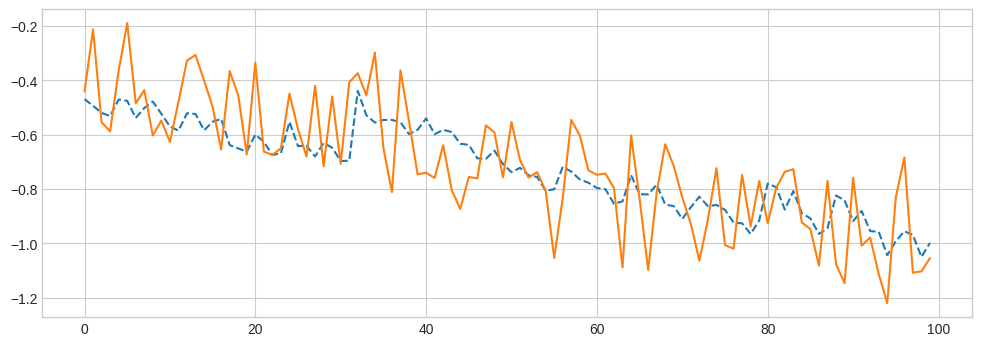

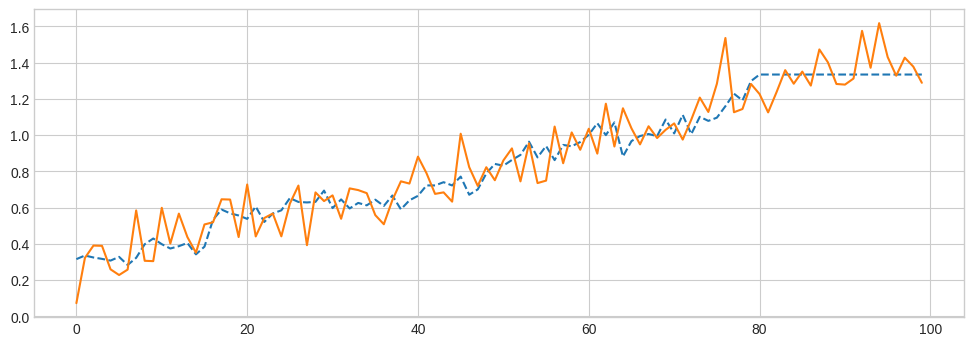

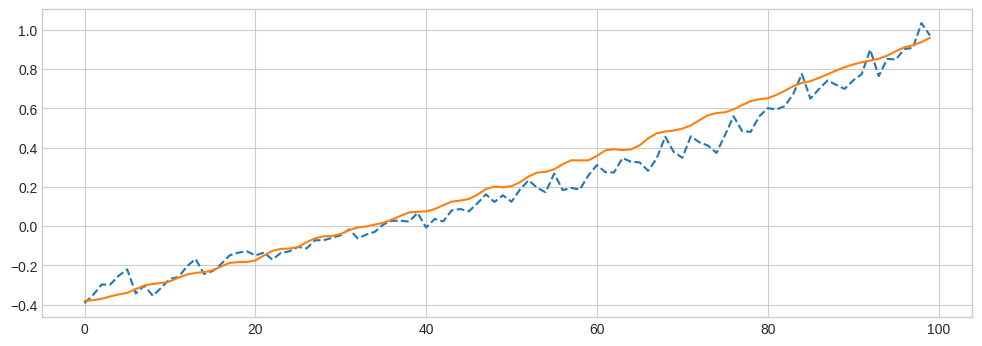

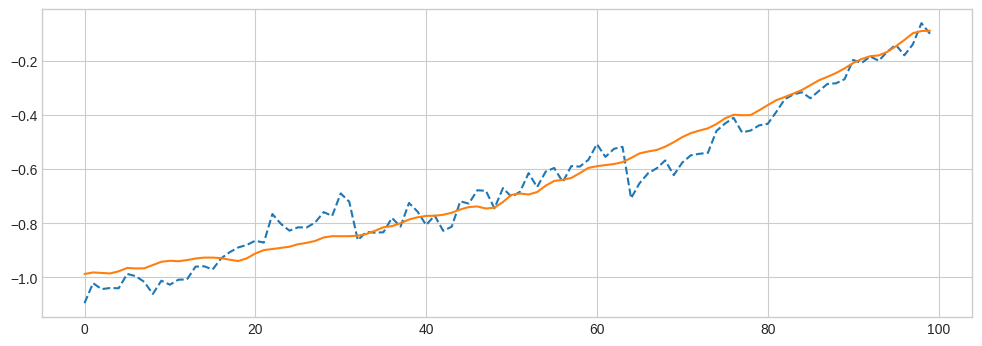

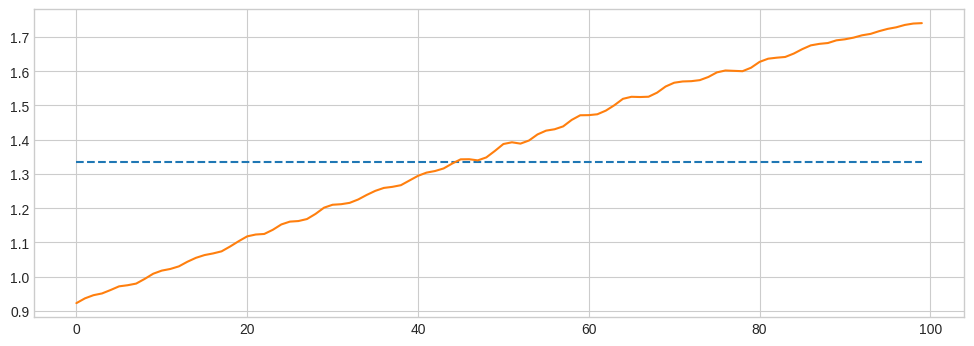

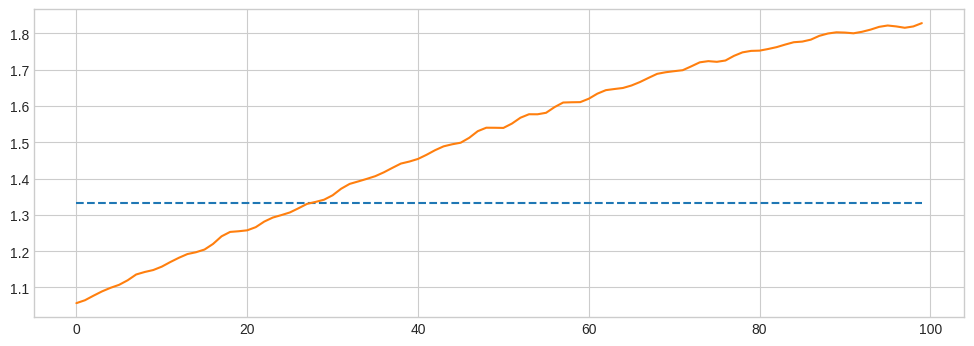

In [130]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:x_limit,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:x_limit,i].to("cpu").detach().numpy())

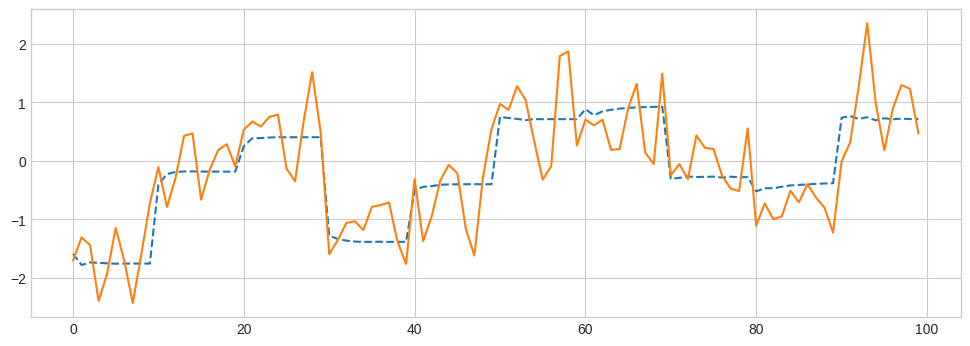

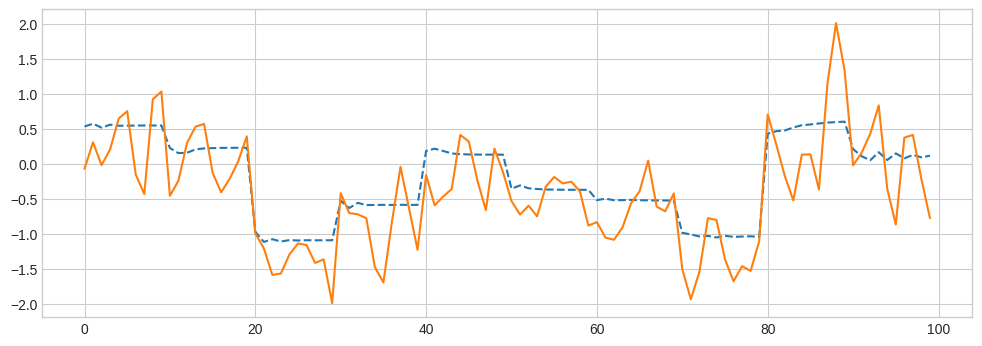

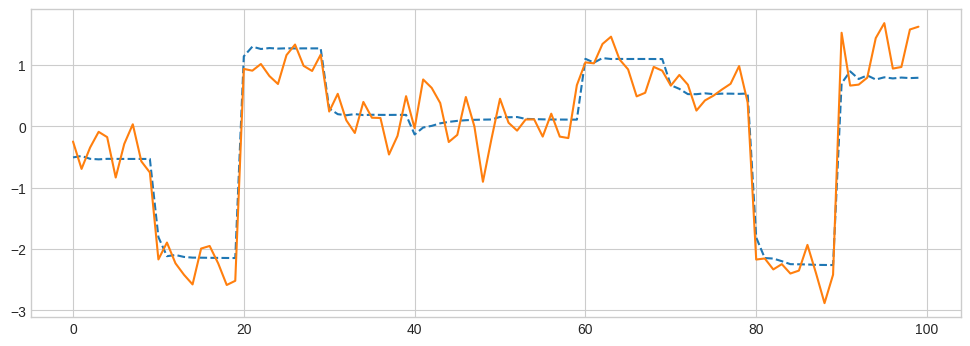

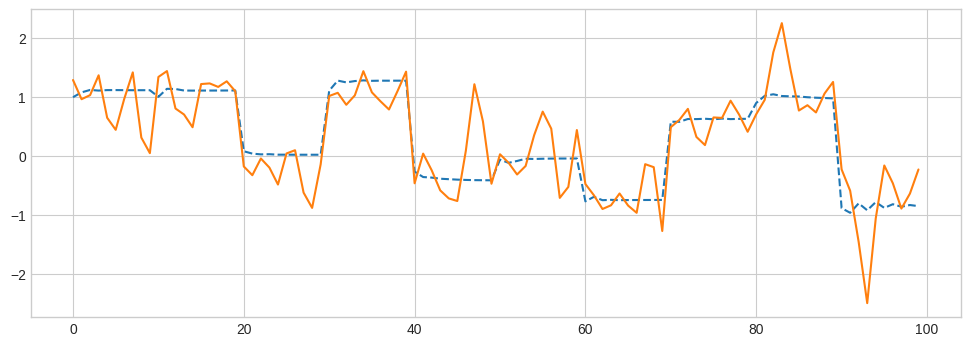

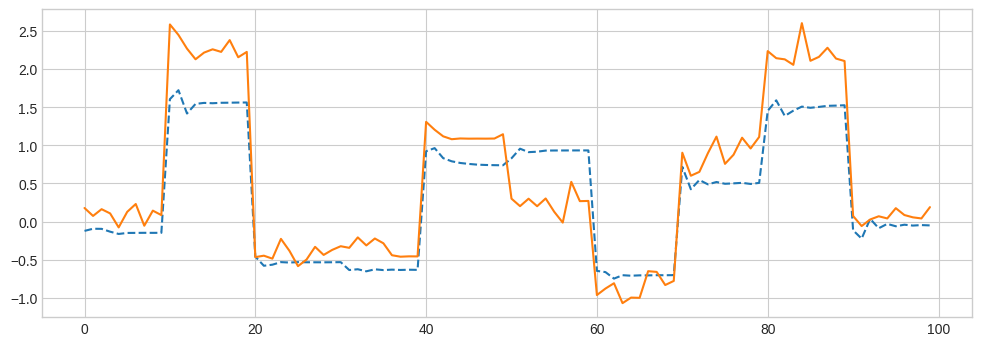

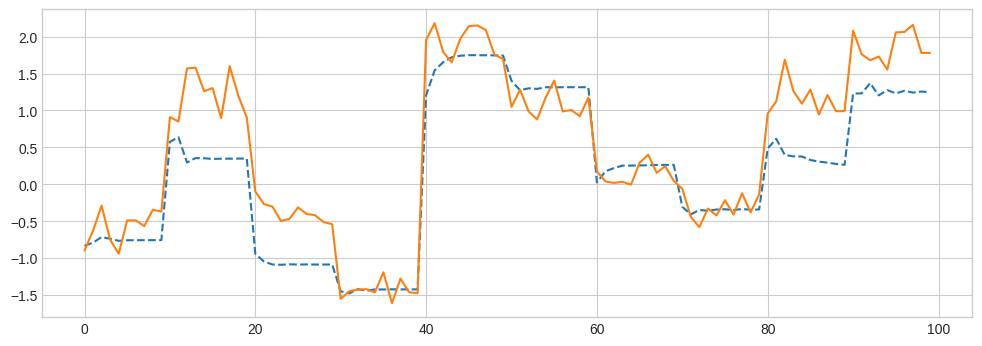

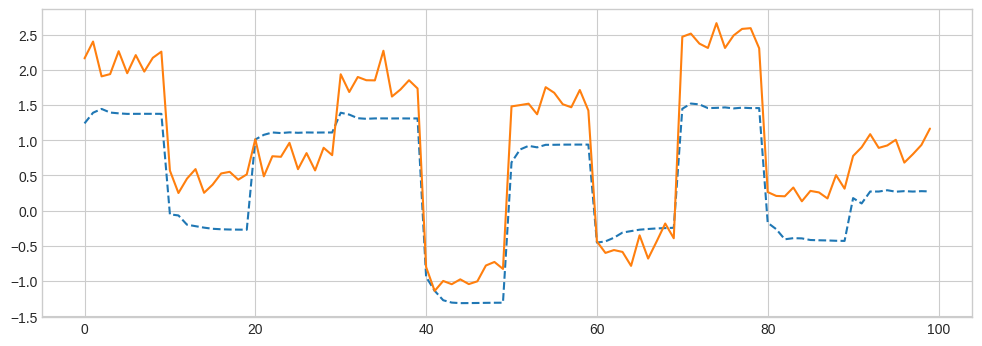

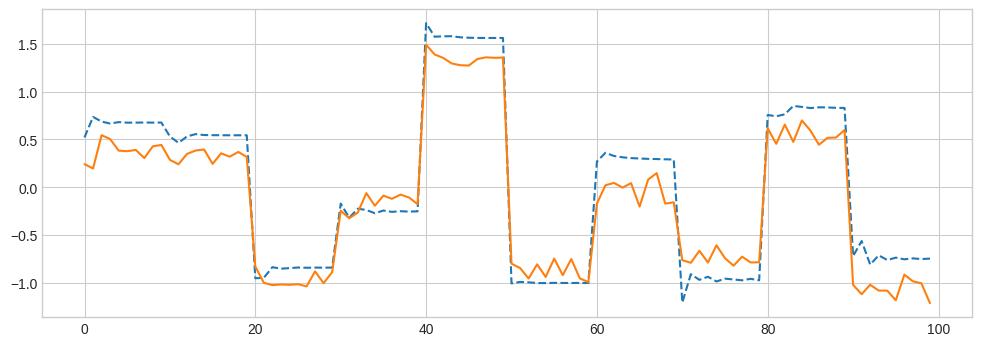

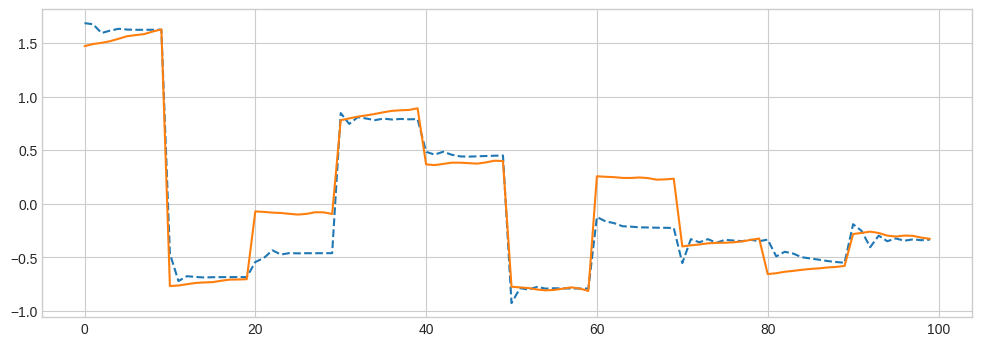

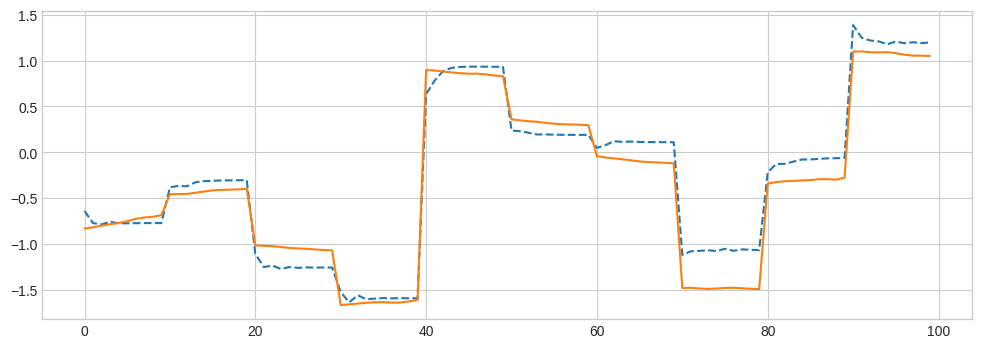

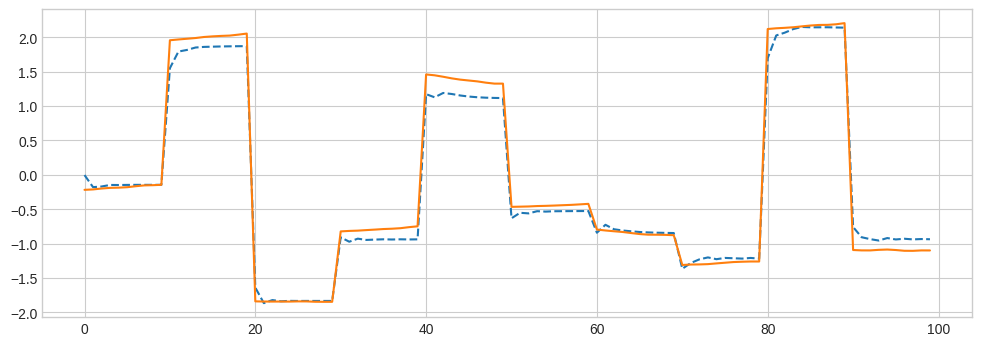

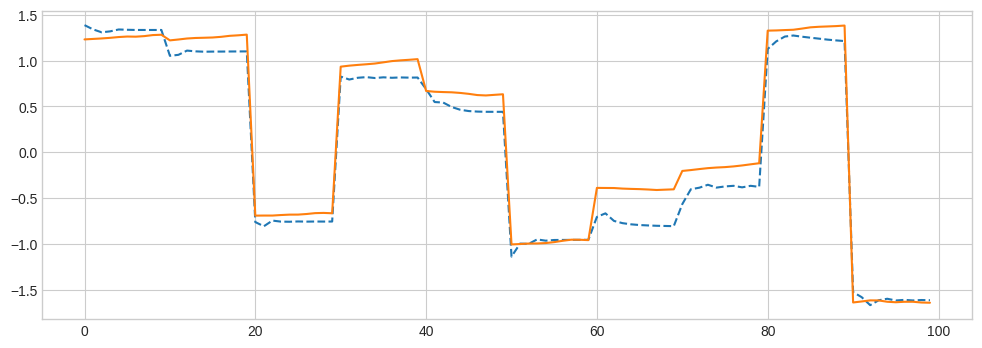

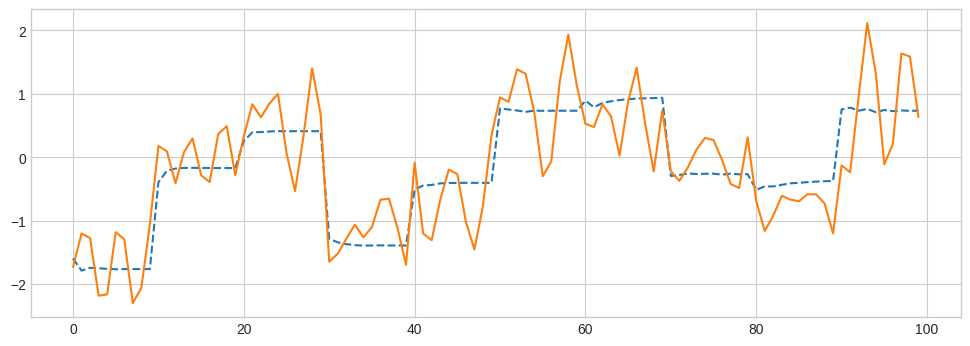

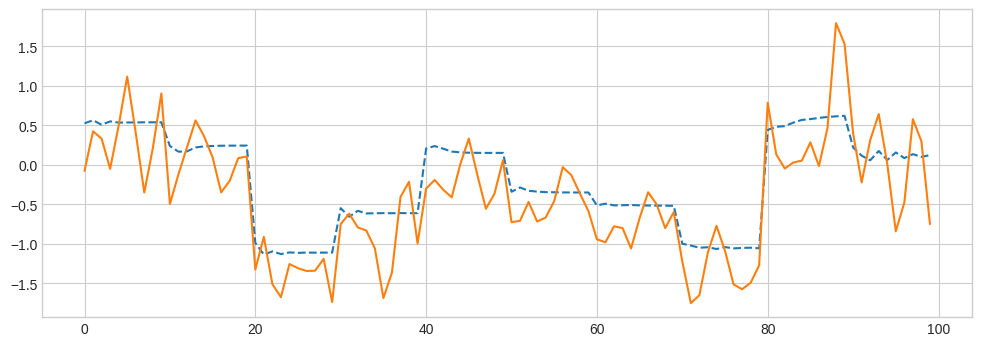

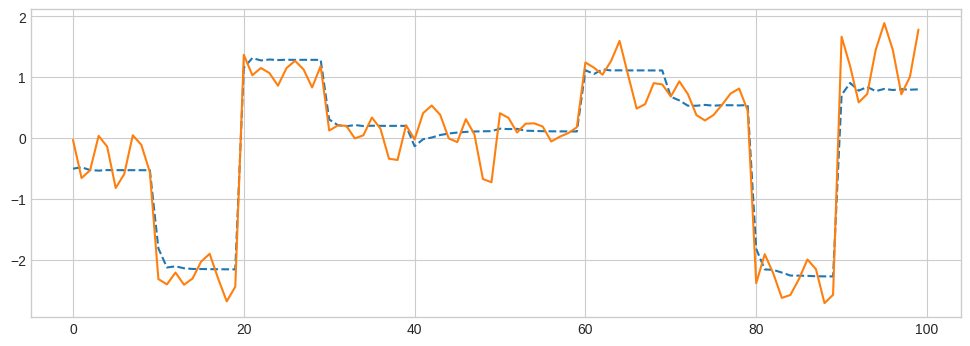

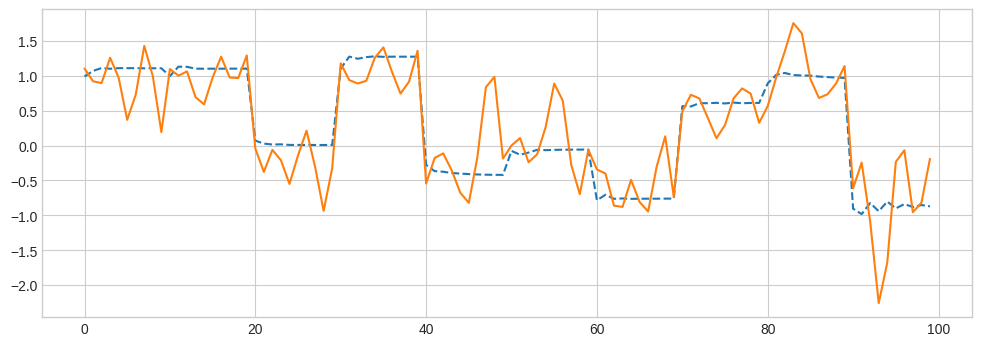

In [44]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

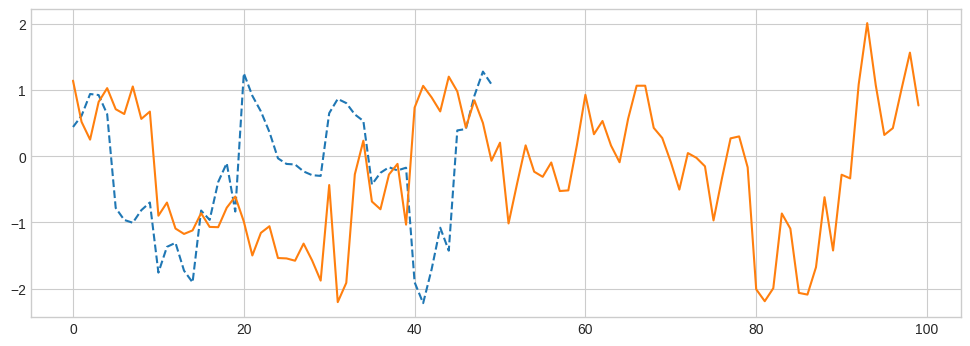

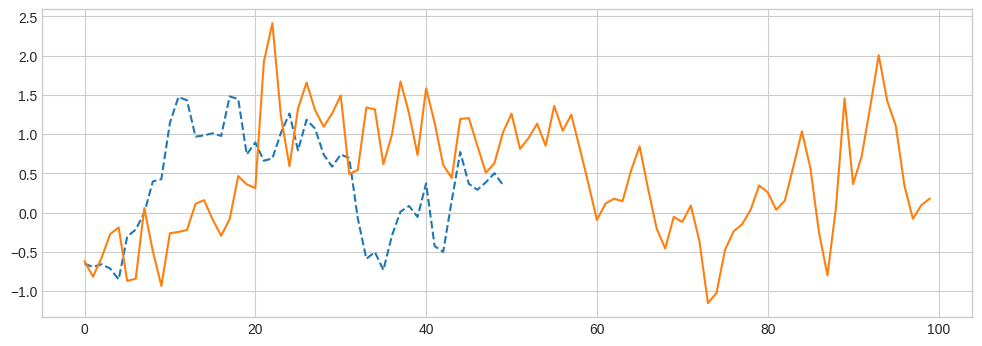

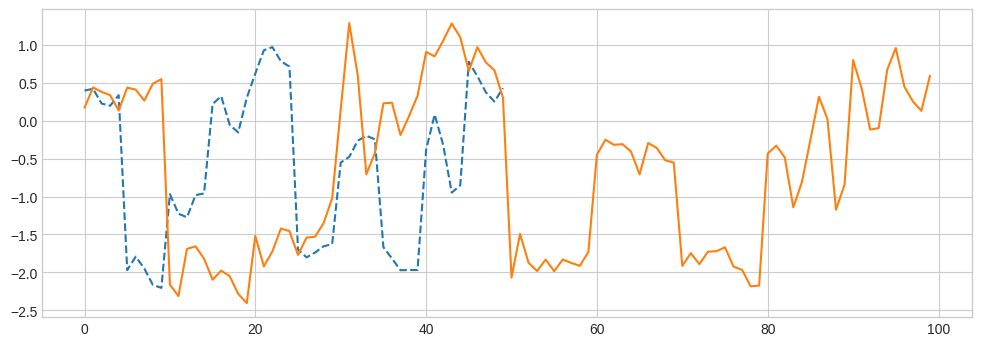

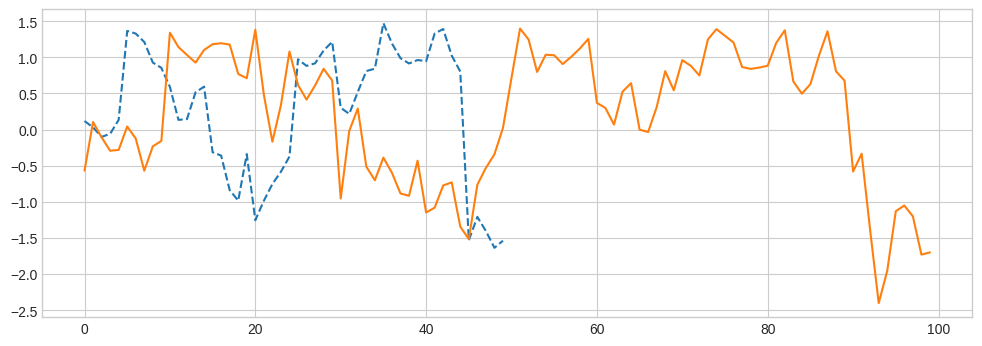

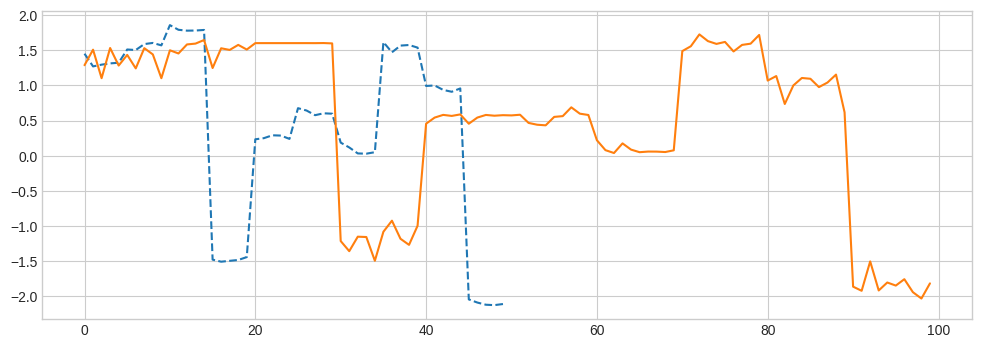

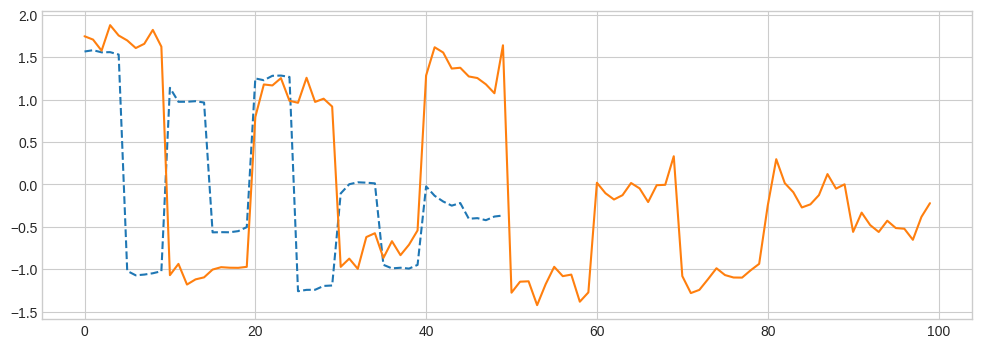

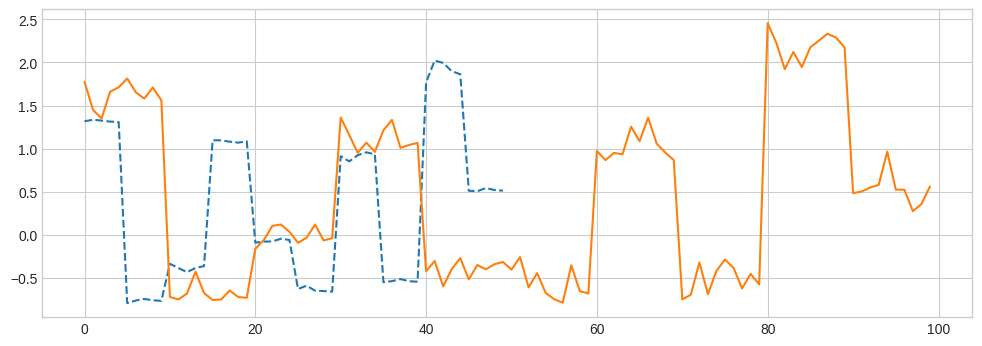

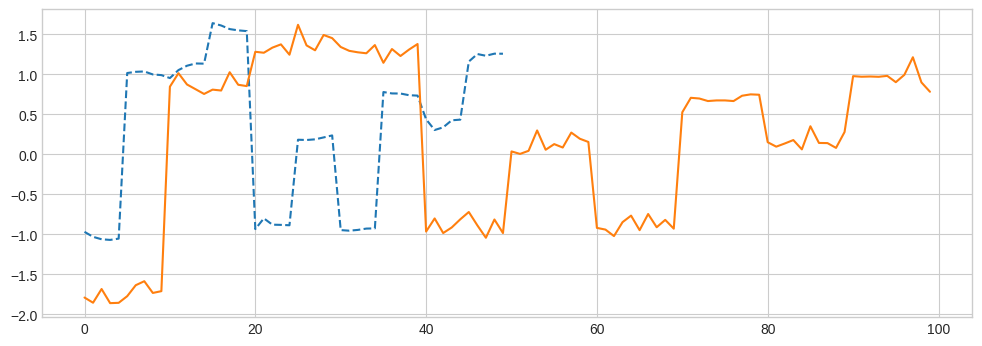

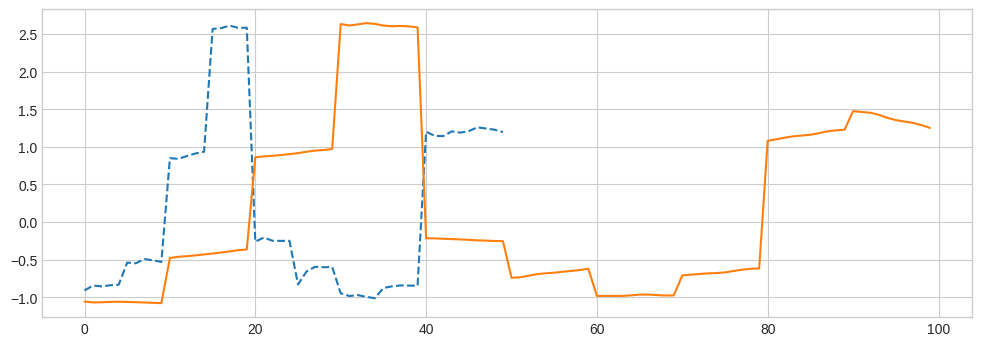

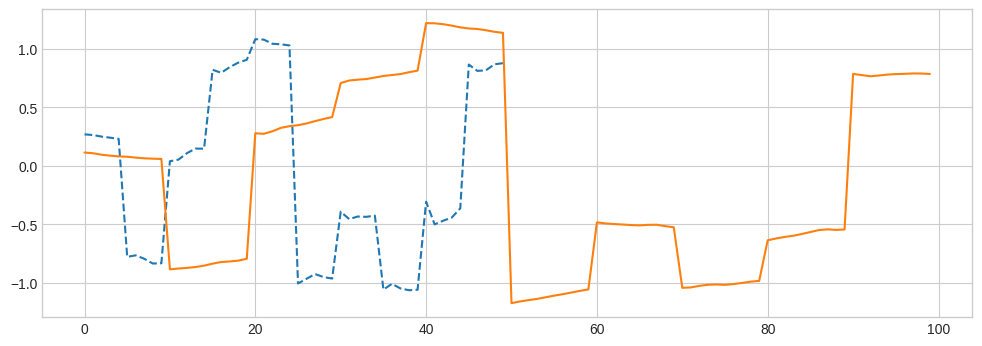

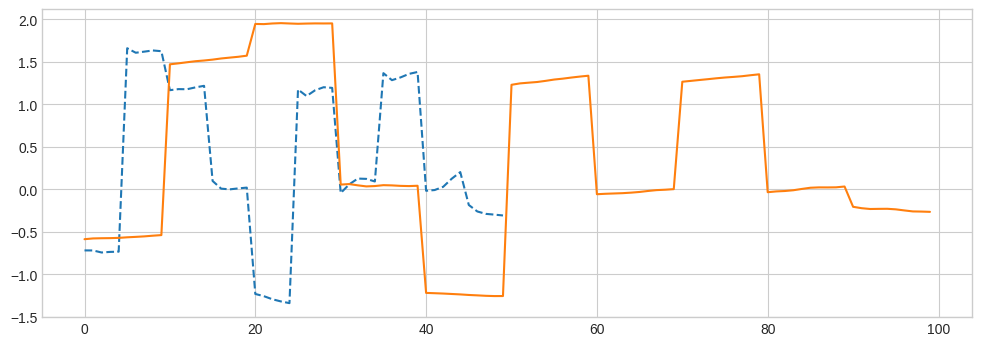

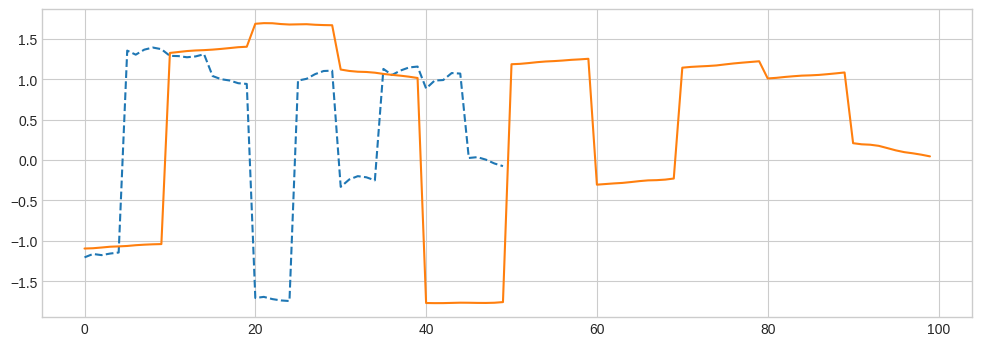

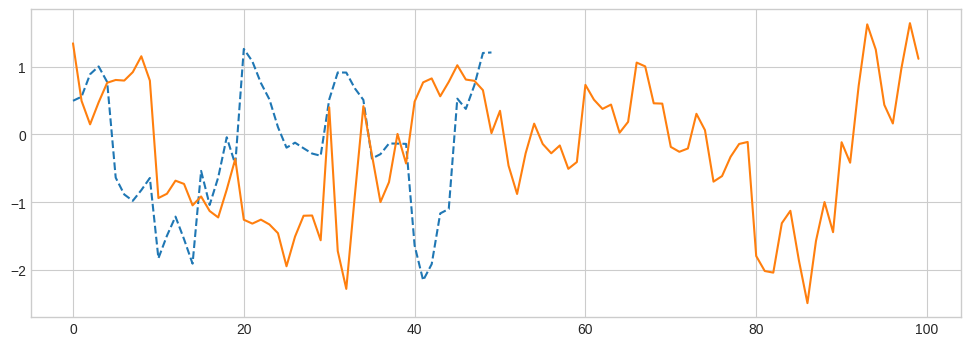

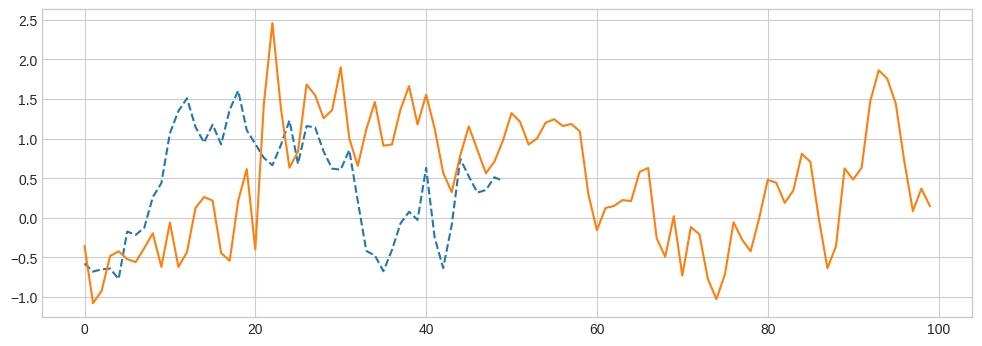

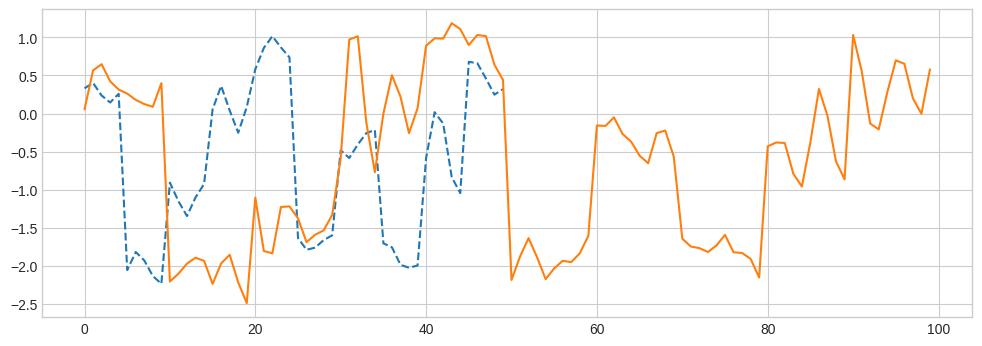

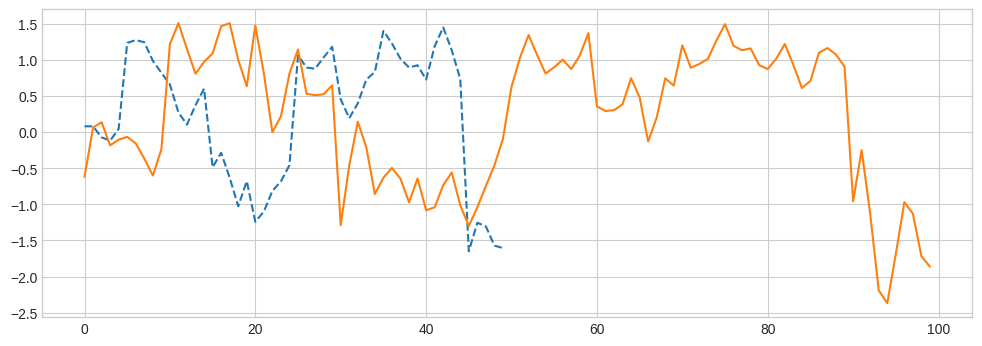

In [15]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

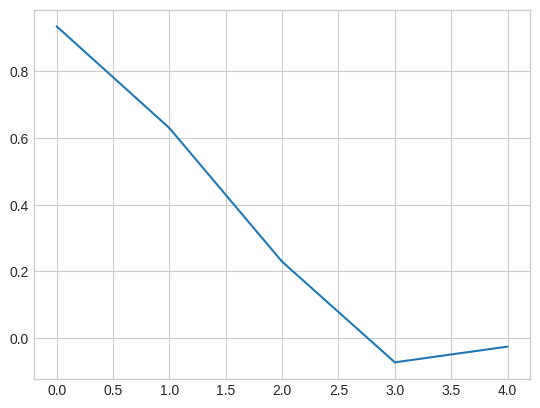

In [18]:
x, y = next(iter(test_iter))
x, enc, yo = model(x.to('cuda'))
feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

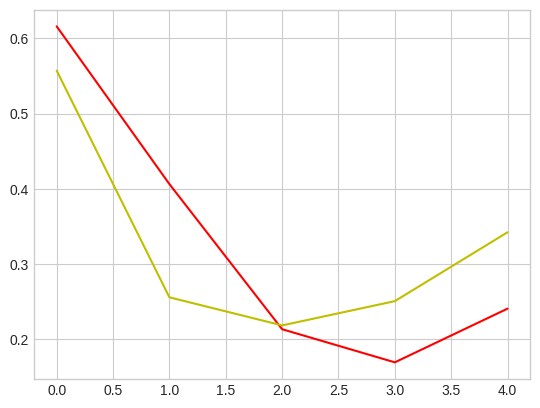

In [19]:
plt.plot(yo[1,:,feat].to("cpu").detach().numpy(), 'r')
plt.plot(y[1,:,feat].to("cpu").detach().numpy(), 'y')

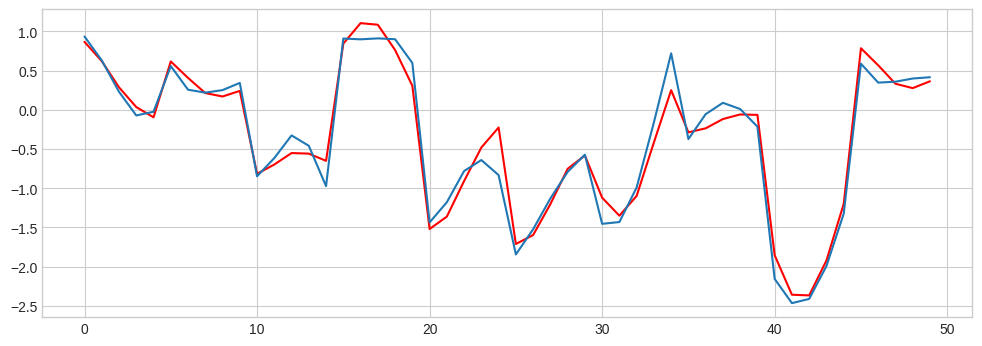

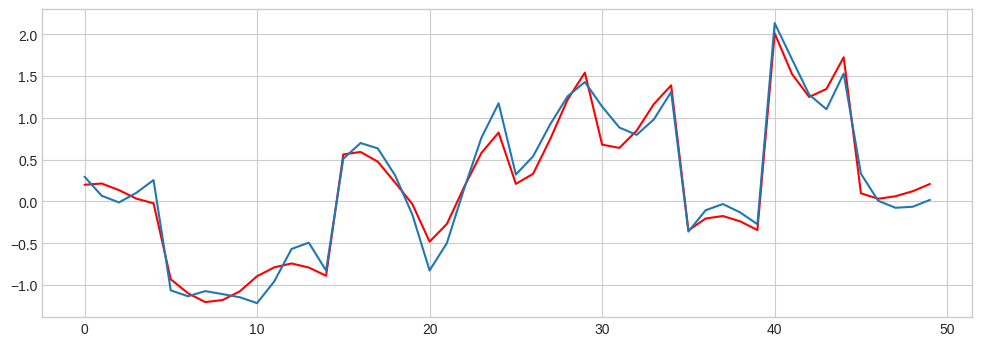

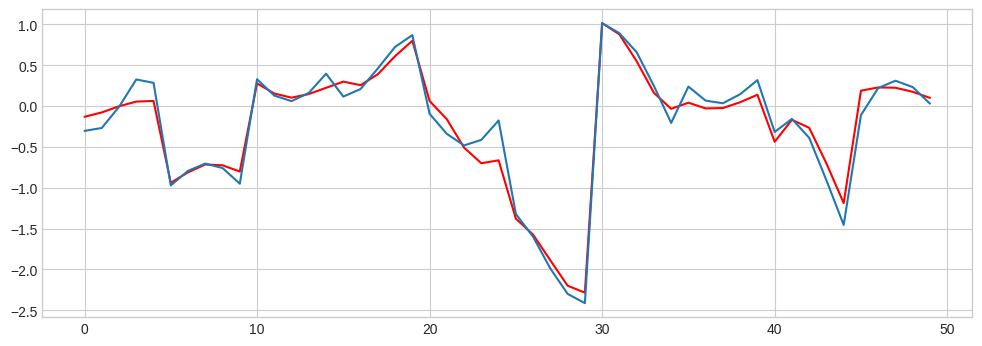

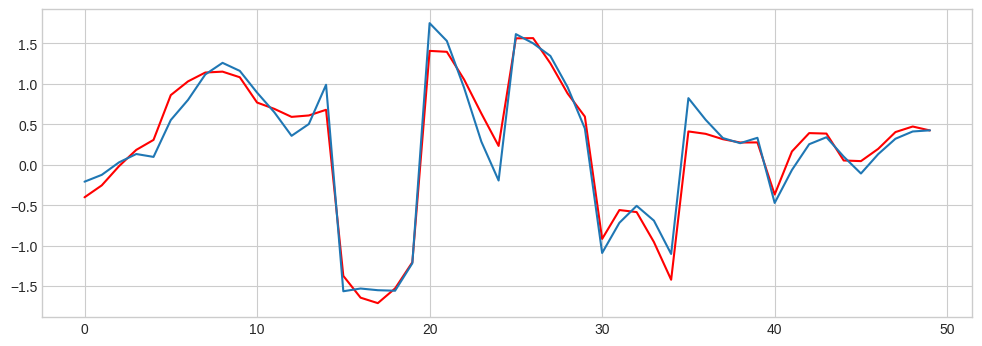

In [20]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:100,i].to("cpu").detach().numpy(), 'r')
    plt.plot(x.flatten(0,1)[:100,i].to("cpu").detach().numpy())

#Inject anomaly

In [21]:
x, y = next(iter(test_iter))

In [25]:
n_std = 5

In [26]:
batch = 5
x_a = x.clone()
change_value = [0, 1,2]
injected = []
for i in range(x.shape[2]):
    print(i)
    if i in change_value:
        print('changing')
        inject = list(x_a[batch ,:, i].cpu().numpy())
        inject_anomaly = [t + n_std*np.std(inject)*random.uniform(0.8,1) for t in inject]
        #x_a[batch,:, i] =  torch.Tensor(fake)
        x_a[batch,:, i] = torch.Tensor(inject_anomaly)
        
        injected.append(i)
    
    if all(x_a[batch,:,i]==x[batch,:,i]):
        print('original tensor and anomalous are the same on features',i)

0
changing
1
changing
2
changing
3
original tensor and anomalous are the same on features 3


In [27]:
idx = batch*sequence_length
x_a, enc, yo_a = model(x_a.to('cuda'))
x, enc, yo = model(x.to('cuda'))
len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

40

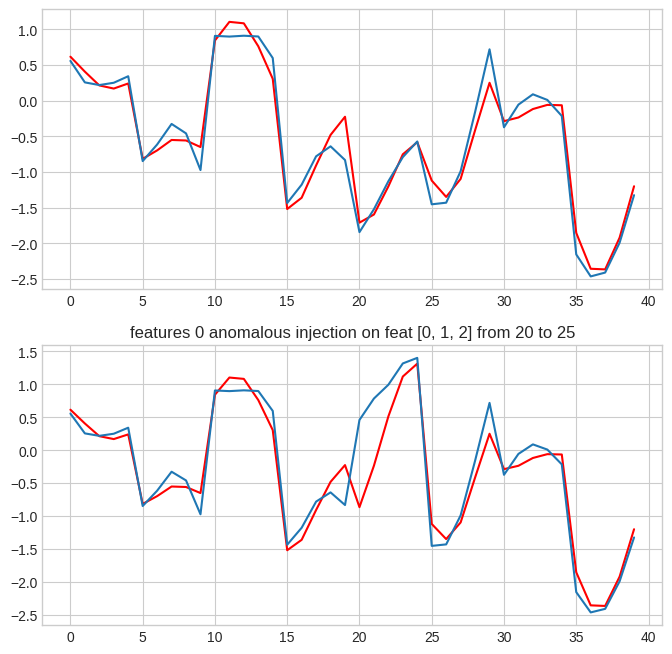

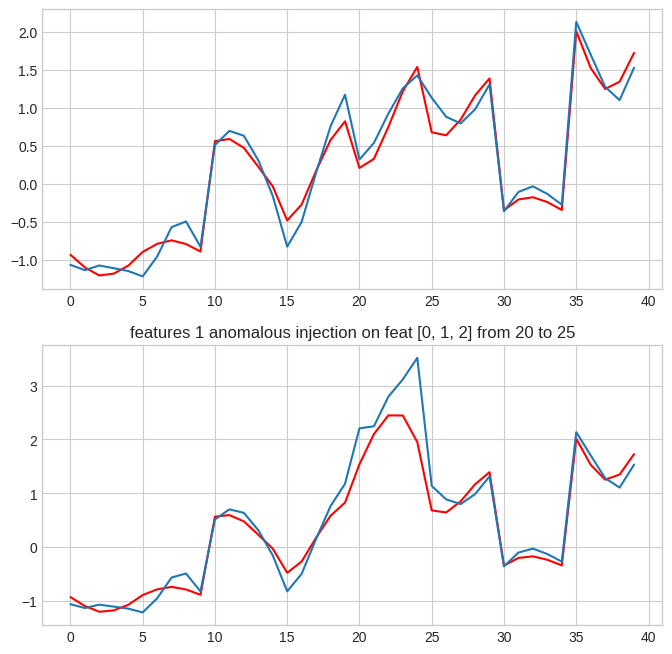

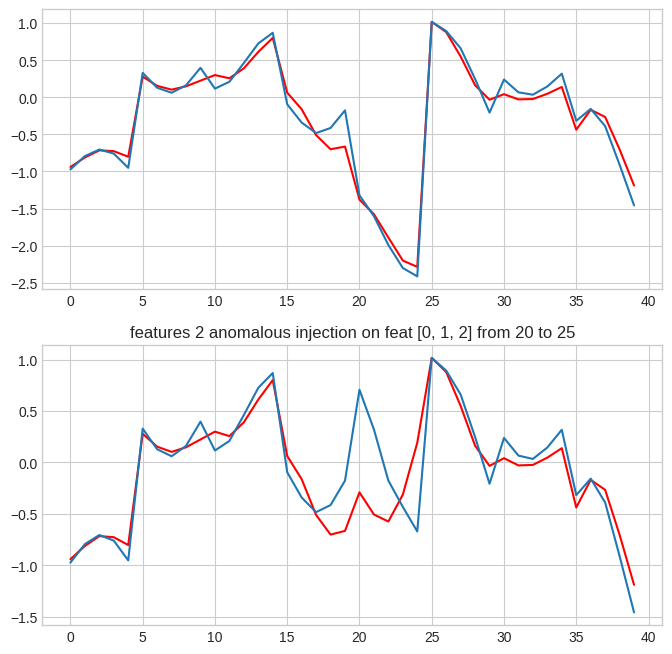

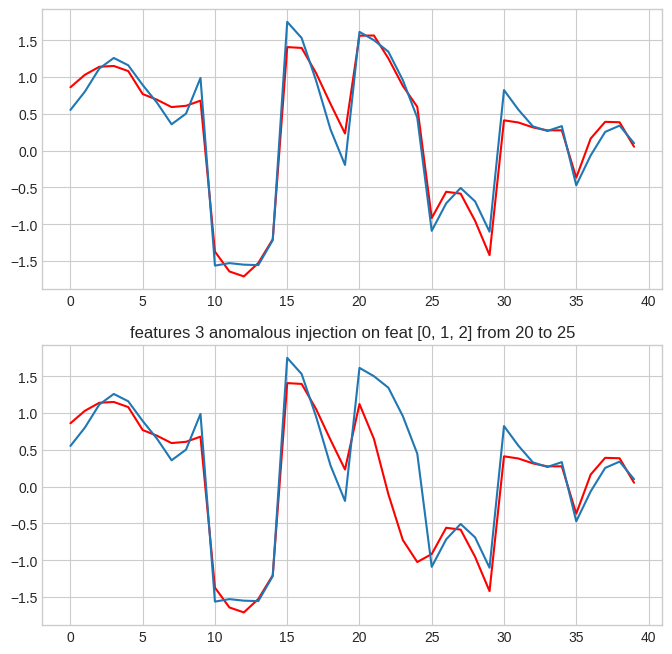

In [28]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig, axs = plt.subplots(2, figsize=(8,8))
    #x = np.linspace(0, sequence_length)
    axs[0].plot(yo.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[0].plot(x.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())
    plt.title('no anomalies')
    axs[1].plot(yo_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[1].plot(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

    an_idx = len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())//2

    plt.title('features {} anomalous injection on feat {} from {} to {}'\
              .format(i ,injected, int(an_idx), int(an_idx)+ batch))